In [1]:
import os
import seaborn
import cv2
import math

import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage.filters import uniform_filter
from scipy.ndimage.measurements import variance
from tqdm import tqdm_notebook

np.seterr(divide='ignore', invalid='ignore');

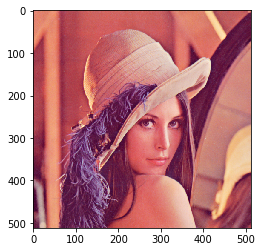

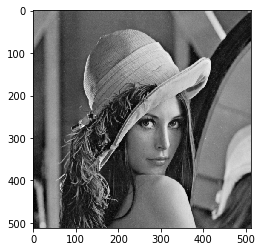

In [2]:
original_image = plt.imread('Lenna.png')
origin_gray = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)

plt.figure()
plt.imshow(original_image)
plt.show()

plt.figure()
plt.imshow(origin_gray,cmap='gray')
plt.show()

In [44]:
def Frost_filter(img, winsize):
    imageType = img.dtype
    mask = cv2.getStructuringElement(cv2.MORPH_RECT, (winsize, winsize))
    origin_gray = np.pad(img, (math.floor(winsize/2),
                               math.floor(winsize/2)), 'symmetric')
    origin_gray = origin_gray.astype('float32')
    [nRows, nCols] = np.shape(origin_gray)
    
    output_image = np.zeros((nRows, nCols))

    grid_size = np.arange(-math.floor(winsize/2), math.floor(winsize/2)+1, 1)
    [xIndGrid, yIndGrid] = np.meshgrid(grid_size, grid_size)
    expWeight = np.exp(-(xIndGrid**2 + yIndGrid**2)**0.5)
    ind = np.arange(math.ceil(winsize/2), nRows-math.floor(winsize/2))
    
    for i in tqdm_notebook(ind):
        for j in ind:
            
            localNeighborhood = origin_gray[i-winsize//2+1: i+
                winsize//2, j-winsize//2+1: j+winsize//2]
            localNeighborhood = localNeighborhood.reshape(winsize*winsize,1)
            localMean = np.mean(localNeighborhood)
            localVar = np.var(localNeighborhood)
            alpha = np.sqrt(localVar)/localMean
            localWeight = alpha*(expWeight**alpha)
            localWeightLin = localWeight.reshape(winsize*winsize,1)
            localWeightLin = localWeightLin/np.sum(localWeightLin[:])
            output_image[i, j] = np.sum(localWeightLin*localNeighborhood)

    output_image = output_image[math.floor(
        winsize/2):nRows-math.floor(winsize/2), math.floor(winsize/2):nCols-math.floor(winsize/2)]
    output_image = output_image.astype(imageType)

    return output_image

In [45]:
outputImage=Frost_filter(origin_gray, 21)

ValueError: cannot reshape array of size 361 into shape (441,1)

In [121]:
winsize = 21

mask = cv2.getStructuringElement(cv2.MORPH_RECT, (winsize, winsize))
origin_gray = np.pad(origin_gray, (math.floor(winsize/2),
                                   math.floor(winsize/2)), 'symmetric')
origin_gray = origin_gray.astype('float32')
[nRows, nCols] = np.shape(origin_gray)
imageType=output_image.dtype
output_image = np.zeros((nRows, nCols))

grid_size = np.arange(-math.floor(winsize/2), math.floor(winsize/2)+1, 1)

[xIndGrid, yIndGrid] = np.meshgrid(grid_size, grid_size)

expWeight = np.exp(-(xIndGrid**2 + yIndGrid**2)**0.5)

for i in np.arange(math.ceil(winsize/2), nRows-math.floor(winsize/2)):
    for j in np.arange(math.ceil(winsize/2), nCols-math.floor(winsize/2)):
        localNeighborhood = origin_gray[i-math.ceil(winsize/2): i+math.floor(
            winsize/2), j-math.ceil(winsize/2): j+math.floor(winsize/2)]
        localNeighborhood = localNeighborhood[mask]
        localMean = np.mean(localNeighborhood[:])
        localVar = np.var(localNeighborhood[:]) + eps
        alpha = math.sqrt(localVar)/localMean
        localWeight = alpha*(expWeight**alpha)
        localWeightLin = localWeight[mask]
        localWeightLin = localWeightLin/np.sum(localWeightLin[:])
        output_image[i, j] = np.sum(localWeightLin*localNeighborhood)
output_image = output_image[math.ceil(
    winsize/2):nRows-math.floor(winsize/2), math.ceil(winsize/2):nCols-math.floor(winsize/2)]
output_image = output_image.astype(imageType)

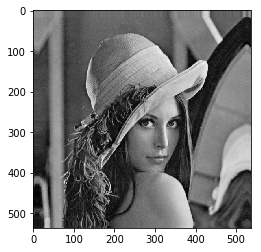

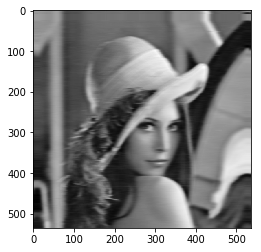

In [127]:
plt.figure()
plt.imshow(origin_gray,cmap='gray')
plt.show()

plt.figure()
plt.imshow(outputImage,cmap='gray')
plt.show()

In [ ]:
def lee_filter(img, size):
    img_mean = uniform_filter(img, (size, size))
    img_sqr_mean = uniform_filter(img**2, (size, size))
    img_variance = img_sqr_mean - img_mean**2

    overall_variance = variance(img)

    img_weights = img_variance / (img_variance + overall_variance)
    img_output = img_mean + img_weights * (img - img_mean)
    return img_output

In [ ]:
def SRAD(img, niter, lamda, rect):
    # make image a double and normalize on[0, 1]
    img = img.astype('double')
    mx = np.max(img[:])
    mn = np.min(img[:])
    img = (img-mn)/(mx-mn)

    # make image a double and normalize on[0, 1]
    [M, N] = np.shape(img)

    # image indices (using boudary conditions)
    iN = np.hstack((np.array(1), np.arange(1, M)))
    iS = np.hstack((np.arange(2, M), np.array(M-1), np.array(M-1)))
    jW = np.hstack((np.array(1), np.arange(1, N)))
    jE = np.hstack((np.arange(2, N), np.array(N-1), np.array(N-1)))

    # log uncompress (also eliminates zero value pixels)
    img = np.exp(img)

    # main algorithm
    for liter in np.arange(1, niter+1):

         # speckle scale function
        Iuniform = img[rect[0]:rect[1], rect[2]:rect[3]]
        q0_squared = np.var(Iuniform[:]) / (pow(np.mean(Iuniform[:]), 2))

        # difference
        dN = img[iN, :] - img
        dS = img[iS, :] - img
        dW = img[:, jW] - img
        dE = img[:, jE] - img

        # normalized discrete gradient magnitude squared (equ 52,53)
        G2 = (pow(dN, 2) + pow(dS, 2) + pow(dW, 2) + pow(dE, 2)) / pow(img, 2)

        # normalized discrete laplacian (equ 54)
        L = (dN + dS + dW + dE)/img

        # ICOV (equ 31/35)
        num = (0.5*G2) - ((1/16)*(pow(L, 2)))
        den = pow((1 + ((1/4)*L)), 2)
        q_squared = num / (den + np.finfo(float).eps)

        # diffusion coefficent (equ 33)
        den = (q_squared - q0_squared) / (q0_squared *
                                          (1 + q0_squared) + np.finfo(float).eps)
        c = 1 / (1 + den)

        # saturate diffusion coefficent
        c[c < 0] = 0
        c[c > 1] = 1

        # divergence (equ 58)
        cS = c[iS, :]
        cE = c[:, jE]
        D = (c*dN) + (cS*dS) + (c*dW) + (cE*dE)

        # update
        img = img + (lamda/4)*D

    J = np.log(img)
    return J